In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia

import numpy as np
import math

import torch
import torch.multiprocessing as multiprocessing
import torch.nn.functional as F

print(torch.cuda.device_count())

1


In [2]:
data_dtype = torch.float32
pos_dtype = torch.int16
device = 'cuda:0'


class Gaussian_Kernel_3D(torch.nn.Module):
    def __init__(self, shape, device, image_dtype=data_dtype):
        super(Gaussian_Kernel_3D, self).__init__()

        self.shape = shape
        self.device = device
        self.image_dtype = image_dtype
        

    def _normalized_basis(self, mu, sigma, num_dim):
        _size = self.shape[num_dim]
        _mu = mu[:, num_dim, None]
        _sigma = sigma[:, num_dim, None]

        return (
            1 / (2 * math.pi * _sigma ** 2) ** (1 / 2) *
            torch.exp(- 1 / 2 * ((_mu - torch.arange(_size, dtype=self.image_dtype, device=self.device)) / _sigma) ** 2)
        )

    def forward(self, x, mu, sigma):
        x = torch.einsum('nz,nt->nzt', [self._normalized_basis(mu, sigma,  num_dim=2), x])
        x = torch.einsum('ny,nzt->nyzt', [self._normalized_basis(mu, sigma, num_dim=1), x])
        x = torch.einsum('nx,nyzt->xyzt', [self._normalized_basis(mu, sigma, num_dim=0), x])

        return x
    
#kernel = Gaussian_Kernel_3D([40,40,40], device=device)

In [3]:
# load test images from hdf5 file
import h5py
data_filename = r'I:\Pu_Temp\Aire\20210927-Thymus_WT_0522_CTP-10-DNA_warpped\Conv_zscan_004.hdf5'

with h5py.File(data_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:,5:-5,561:600,562:600]
    #combo_ids = _grp['ids'][:]

    
# get the codebook

# load codebook
import pandas as pd
codebook_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-10_Aire\Summary_tables\CTP10-Aire_codebook.csv')
codebook_df.set_index('name')
codebook = np.array(codebook_df[[_name for _name in codebook_df.columns if 'NDB_' in _name]])
print(codebook.shape)


(209, 50)


In [4]:
def normalize(x, mask=None, std=12.0, num_iters=64):
    size = x.shape[-1]

    _x = x.view(-1, size)
    w = torch.ones_like(_x)
    for num_iter in range(num_iters):
        _mean = torch.sum(w * _x, dim=0) / torch.sum(w, dim=0)
        w = torch.exp(-1 / 2 * ((_x - _mean) / std) ** 2)

    x = torch.clamp(x - _mean, min=0)
    if mask is None:
        x = x / torch.mean(x.view(-1, size) ** 2, dim=0).sqrt()
    else:
        x = x / torch.mean(x[mask] ** 2, dim=0).sqrt()

    return x

# copy image and encoding matrix into GPU
H = torch.tensor(codebook, dtype=data_dtype).to(device='cuda:0')
#H = torch.cat([H, torch.ones(1, H.shape[1], dtype=data_dtype).to(device=device)], dim=0) # background
Y = torch.tensor(combo_ims.transpose(1,2,3,0).astype(np.float32), dtype=data_dtype).to(device='cuda:0')
#C = torch.tensor(C, dtype=dtype).to(device=torch.cuda.device)

Y = normalize(Y,)

In [5]:
n_regs, n_bits = H.shape
size_z, size_x, size_y, n_bits = Y.shape

print(n_regs, n_bits)

209 50


In [6]:
# version1: seed all possible bits if having 1 bit overlapping
seed_list = [ia.spot_tools.fitting.get_seeds(_im, th_seed=800) for _im in combo_ims]

seeding_mat = np.zeros(list(Y.shape[:-1])+[n_regs])
for _bit, _seeds in enumerate(seed_list):
    for _seed in _seeds:
        seeding_mat[tuple(list(_seed.astype(np.int32)))][np.where(codebook[:,_bit])[0]] = 1
    print(seeding_mat.sum())

130.0
442.0
598.0
814.0
957.0
1204.0
1321.0
1489.0
1681.0
1850.0
1967.0
2111.0
2137.0
2254.0
2449.0
2653.0
2808.0
3120.0
3300.0
3612.0
3794.0
4041.0
4209.0
4425.0
4532.0
4736.0
4904.0
5156.0
5288.0
5508.0
5640.0
5772.0
5954.0
6230.0
6334.0
6685.0
6879.0
7216.0
7384.0
7696.0
7878.0
8094.0
8226.0
8512.0
8704.0
8963.0
8999.0
9193.0
9370.0
9669.0


In [24]:
# version2: seed when neighboring bits have at least 2 bits match
seed_list = [ia.spot_tools.fitting.get_seeds(_im, th_seed=800, min_edge_distance=0) for _im in combo_ims]

seeding_mat = np.zeros(list(Y.shape[:-1])+[n_regs])

neighbor_radius = 4
from scipy.spatial.distance import pdist

all_seeds = np.concatenate([_seeds for _seeds in seed_list]) 
all_bits = np.concatenate([_i*np.ones(len(_seeds), dtype=np.int32) for _i,_seeds in enumerate(seed_list)])

sel_seeds = []
sel_bits = []

for _bit, _seeds in enumerate(seed_list):
    # check valid overlapping bits
    _valid_overlaps = [_b for _b in np.where(codebook[np.where(codebook[:,_bit])[0]].sum(0) > 0)[0] if _b != _bit]
    for _seed in _seeds:
        _dists = np.linalg.norm(all_seeds - _seed, axis=1)
        _neighbors = np.where(_dists < neighbor_radius)[0]
        _nb_bits = all_bits[_neighbors]
        
        for _b, _nb in zip(_nb_bits, _neighbors):
            if _b in _valid_overlaps:
                # get seed region id
                _nb_seed = all_seeds[_nb]
                #print(_nb_seed, _seed)
                # get region id for this seed
                _seed_reg_ids = np.intersect1d(np.where(codebook[:,_b])[0], np.where(codebook[:,_bit])[0])
                # append the seed
                seeding_mat[tuple(list(np.round((_seed+_nb_seed)/2).astype(np.int32)))][_seed_reg_ids] = 1        
                
                if len(sel_seeds)==0 or np.linalg.norm(np.array(sel_seeds) - (_seed+_nb_seed)/2, axis=1).min() > 0 :
                    sel_seeds.append((_seed+_nb_seed)/2)
                    sel_bits.append(_seed_reg_ids[0])
                
    print(seeding_mat.sum(), len(sel_seeds))


33.0 33
137.0 135
204.0 199
284.0 277
353.0 342
427.0 416
477.0 465
541.0 530
592.0 575
647.0 629
690.0 672
745.0 732
767.0 754
800.0 786
862.0 849
943.0 927
999.0 978
1068.0 1043
1115.0 1090
1166.0 1140
1209.0 1181
1265.0 1235
1321.0 1291
1392.0 1358
1427.0 1385
1466.0 1424
1521.0 1481
1587.0 1544
1628.0 1581
1667.0 1615
1687.0 1633
1716.0 1662
1746.0 1691
1773.0 1718
1799.0 1741
1856.0 1795
1885.0 1823
1953.0 1886
1978.0 1906
2014.0 1943
2024.0 1952
2042.0 1968
2049.0 1975
2054.0 1980
2074.0 1999
2087.0 2007
2089.0 2009
2089.0 2009
2098.0 2017
2098.0 2017


In [ ]:
# version3: for each pixel, try to roughly assign identities


In [8]:
np.array(sel_seeds).shape

(3832, 3)

In [26]:
init_sigma = 1.8
# 1.75

#mu = torch.tensor(np.array(np.where(seeding_mat)[:len(np.shape(Y))-1]).transpose(),
#                  dtype=data_dtype).to(device=device)
mu = torch.tensor(np.array(sel_seeds), dtype=data_dtype).to(device=device)

mu_delta = torch.zeros_like(mu).to(device=device).requires_grad_()

sigma = torch.full_like(mu, init_sigma).to(device=device).requires_grad_()

#X = torch.tensor(seeding_mat.reshape(-1, n_regs), dtype=data_dtype).to(device=device).requires_grad_()
#X = torch.full((len(mu), n_regs), 1.0).to(device=device).requires_grad_()
# create X
_cpu_x = np.ones([len(mu), n_regs]) * 0.1
#_cpu_x[:,-1] = 0.5 # background
_cpu_x[np.arange(len(mu)), np.array(sel_bits)] = 1

X = torch.tensor(_cpu_x, dtype=data_dtype).to(device=device).requires_grad_()

# scaling factor for bits
a = torch.ones(n_bits).to(device=device).requires_grad_()

D = Gaussian_Kernel_3D(shape=np.shape(Y)[:-1], device=device)

optimizer = torch.optim.Adam([mu_delta, sigma, X, a], lr=2e-1)
# 2e-2 gives good result
# currently use a full mask, allow everything to pass
Y_mask = torch.full(np.shape(Y), 1.0).to(device=device)

recorded_loss = []
device_id = 0

100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:12<00:00, 82.20it/s]


<IPython.core.display.Javascript object>


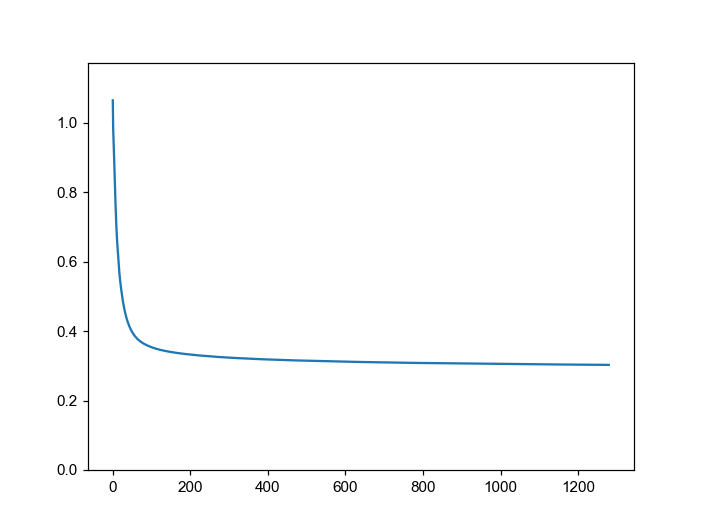

In [37]:
from tqdm import tqdm
num_iter = 1024

#prog = tqdm.trange(num_iter, position=device_id + 1)

for _iter in tqdm(range(num_iter)):
    #prog.set_description(f'iter-{data}')
    
    # initialize optimizer gradients
    optimizer.zero_grad()
    # update local variables in each iteration
    _mu = mu + mu_delta
    _sigma = torch.abs(sigma)
    # select only gaussians with positive parameters ?
    _X = F.relu(X)
    sel = (_X != 0).any(dim=1)
    if sel.sum() == 0:
        break
    
    _Y = D(_X[sel].matmul(H), mu=_mu[sel], sigma=_sigma[sel]) * a
    Y_delta = (_Y - Y) ** 2
    
    # calculate loss function
    loss_Y = (Y_delta * Y_mask).mean()
    loss_X = _X.mean()
    loss_mu = torch.mean(mu_delta ** 2) 
    loss_sigma = torch.mean((_sigma - init_sigma) ** 2)
    loss = loss_Y + 1e0 * loss_X + 1e-1 * loss_mu + 1e-1 * loss_sigma 
    
    recorded_loss.append(loss.cpu().detach().numpy())
    # calculate gradient
    loss.backward()
    # run optimizer for this iteration
    optimizer.step()

plt.figure()
plt.plot(recorded_loss)
plt.ylim([0, recorded_loss[0]*1.1])
plt.show()

In [38]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   57748 KB |    3031 MB |    3330 GB |    3330 GB |
|       from large pool |   57437 KB |    3025 MB |    3302 GB |    3302 GB |
|       from small pool |     311 KB |       8 MB |      28 GB |      28 GB |
|---------------------------------------------------------------------------|
| Active memory         |   57748 KB |    3031 MB |    3330 GB |    3330 GB |
|       from large pool |   57437 KB |    3025 MB |    3302 GB |

In [39]:
input_Y = Y.cpu().detach().numpy().transpose(3,0,1,2)
simulated_Y = _Y.cpu().detach().numpy().transpose(3,0,1,2)

<IPython.core.display.Javascript object>


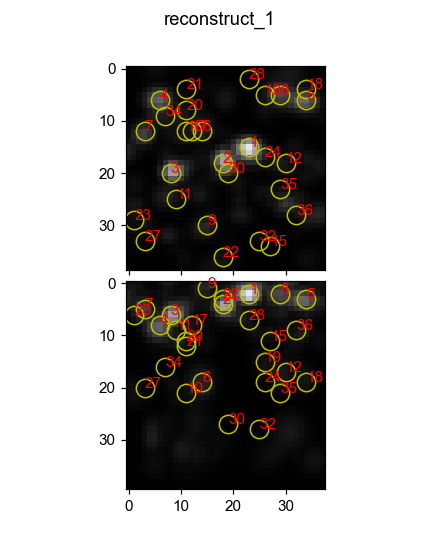

In [40]:
# compare input and reconstructed image
_ims = []
_im_names = []

coord_dict = {
    'coords':[],
    'class_ids':[],
}

for _i, (_raw_im, _recon_im) in enumerate(zip(input_Y, simulated_Y)):
    
    _seeds = seed_list[_i]
    
    _ims.extend([_raw_im, _recon_im])
    _im_names.extend([f"raw_{_i}",f"reconstruct_{_i}"])
    
    coord_dict['coords'].extend([np.flipud(_coord) for _coord in _seeds])
    coord_dict['class_ids'].extend(list(np.ones(len(_seeds),dtype=np.int)*_i*2 ) )
    coord_dict['coords'].extend([np.flipud(_coord) for _coord in _seeds])
    coord_dict['class_ids'].extend(list(np.ones(len(_seeds),dtype=np.int)*_i*2+1 ) )

    
%matplotlib notebook   
ia.visual_tools.imshow_mark_3d_v2(_ims, image_names=_im_names, given_dic=coord_dict,)

In [41]:
_image_by_bit = D(_X[sel], mu=_mu[sel], sigma=_sigma[sel]).cpu().detach().numpy().transpose(3,0,1,2)

<IPython.core.display.Javascript object>


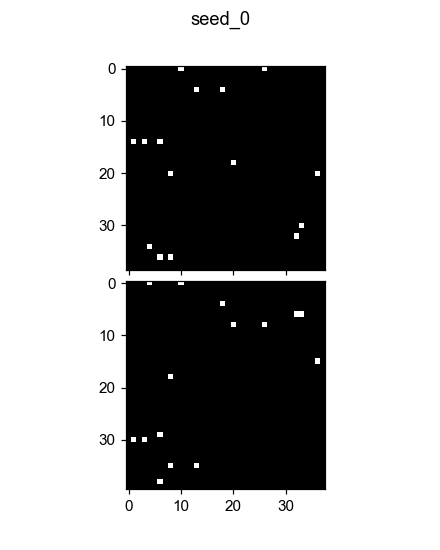

In [42]:
# compare seeded and decoded image
_ims = []
_im_names = []
for _i, (_seed_im, _im) in enumerate(zip(seeding_mat.transpose(3,0,1,2), _image_by_bit)):
    _ims.extend([_seed_im, _im])
    _im_names.extend([f"seed_{_i}",f"decode_{_i}"])
    
ia.visual_tools.imshow_mark_3d_v2(_ims, image_names=_im_names)

<IPython.core.display.Javascript object>


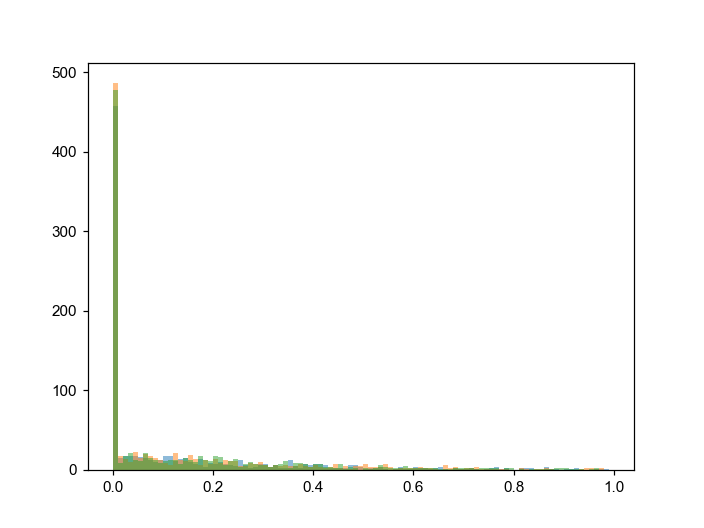

In [43]:
plt.figure()
for _sgms in mu_delta.cpu().detach().numpy().transpose():
    plt.hist(_sgms, bins=np.arange(0,1,0.01), alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


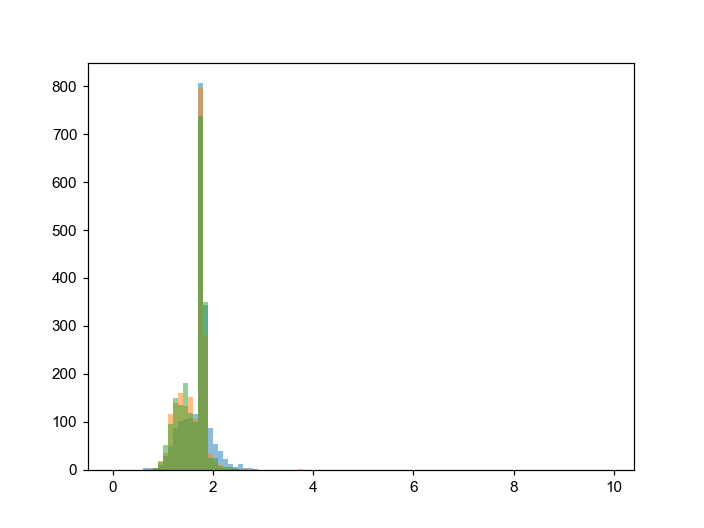

In [44]:
plt.figure()
for _sgms in _sigma.cpu().detach().numpy().transpose():
    plt.hist(_sgms, bins=np.arange(0,10,0.1), alpha=0.5)
plt.show()

In [26]:
mu_delta.max(1)

torch.return_types.max(
values=tensor([ 0.0234,  0.0827,  0.0268,  ..., -0.0026,  0.0023,  0.0017],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0,  ..., 2, 2, 2], device='cuda:0'))

In [76]:
def make_mask(G, C, device):
    mask = torch.abs(G.unsqueeze(-2) - C) < torch.tensor(FLAGS.chromosome_size, dtype=dtype).to(device=device) / 2
    return mask.all(dim=-1).any(dim=-1)

In [95]:
ia.io_tools.load.find_image_background(combo_ims[4])

25.0

In [108]:
seed_list = [ia.spot_tools.fitting.get_seeds(_im, th_seed=800) for _im in combo_ims]

In [113]:
%matplotlib notebook
%matplotlib notebook
## visualize

coord_dict = {
    'coords':[],
    'class_ids':[],
}
for _i, _seeds in enumerate(seed_list):
    coord_dict['coords'].extend([np.flipud(_coord) for _coord in _seeds])
    coord_dict['class_ids'].extend(list(np.ones(len(_seeds),dtype=np.int)*_i ) )



im_class = ia.visual_tools.imshow_mark_3d_v2(combo_ims, 
                               given_dic=coord_dict,
                               save_file=None,
                               )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


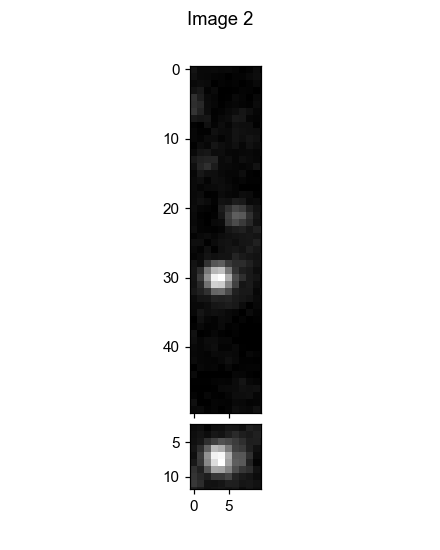

In [107]:
ia.visual_tools.imshow_mark_3d_v2([combo_ims[0]>1000, combo_ims[0]])

## merge all the seeds

627.0


In [77]:
M = make_mask(G, C, device=device)


NameError: name 'C' is not defined

In [79]:
Y_new = normalize(Y)

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 8.58829468e-02, 0.00000000e+00, ...,
          2.98319105e-02, 0.00000000e+00, 4.99417968e-02],
         [0.00000000e+00, 3.54859419e-02, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 5.98177798e-02],
        

<IPython.core.display.Javascript object>


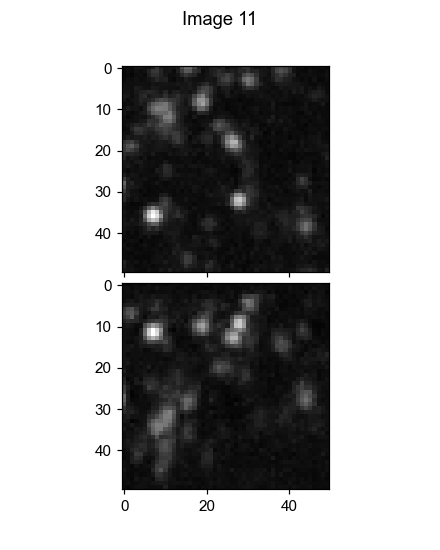

In [90]:
%matplotlib notebook
ia.visual_tools.imshow_mark_3d_v2(combo_ims)

<IPython.core.display.Javascript object>


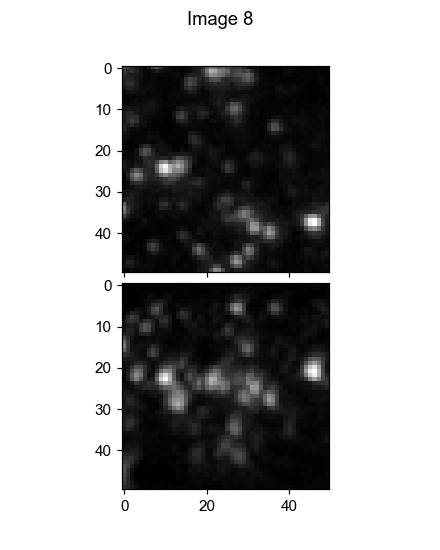

In [89]:
%matplotlib notebook
ia.visual_tools.imshow_mark_3d_v2(Y_new.cpu().numpy())

In [68]:
X.matmul(H)

RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [49]:
a

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', requires_grad=True)


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 284.29 GiB (GPU 0; 12.00 GiB total capacity; 3.76 GiB already allocated; 5.32 GiB free; 3.78 GiB reserved in total by PyTorch)

In [35]:
?F.relu

In [118]:
mu[66]

tensor([ 0,  0, 66], device='cuda:0', dtype=torch.int16)

In [54]:
torch.cuda.empty_cache()

In [190]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  122043 KB |    3057 MB |   62663 GB |   62663 GB |
|       from large pool |  116146 KB |    3049 MB |   61812 GB |   61811 GB |
|       from small pool |    5896 KB |      16 MB |     851 GB |     851 GB |
|---------------------------------------------------------------------------|
| Active memory         |  122043 KB |    3057 MB |   62663 GB |   62663 GB |
|       from large pool |  116146 KB |    3049 MB |   61812 GB |

In [14]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   65339 KB |    3523 MB |    6524 GB |    6524 GB |
|       from large pool |   64794 KB |    3516 MB |    6472 GB |    6472 GB |
|       from small pool |     544 KB |       9 MB |      51 GB |      51 GB |
|---------------------------------------------------------------------------|
| Active memory         |   65339 KB |    3523 MB |    6524 GB |    6524 GB |
|       from large pool |   64794 KB |    3516 MB |    6472 GB |

<IPython.core.display.Javascript object>


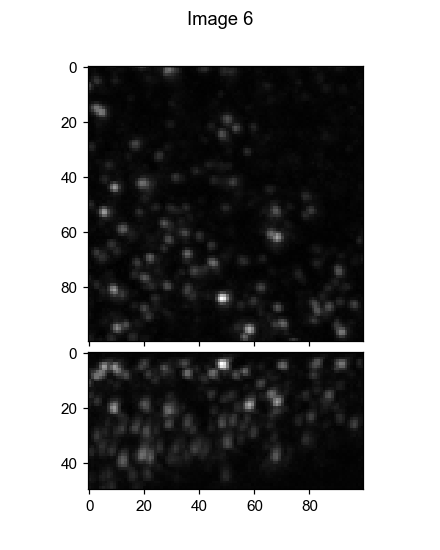

In [38]:
%matplotlib notebook
ia.visual_tools.imshow_mark_3d_v2(combo_ims)